# Introduction to Julia for Data Science
## Classical predictive models (11:00-12:30)
Day 2 (Wednesday, Jan 18, 2023)


### Teaching objectives:
- Student will understand and know how to use in Julia Data Generating Process for Linear Regression Model
- Student will know how to estimate in Julia linear regression model using Ordinary Least Square
- Student will know the basic statistical properties of Ordinary Least Square and be able to demonstrate them in Monte Carlo simulations in Julia
- Student will be acquainted with omitted variable problem and its consequences. 

### Agenda (11:00 – 12:30)
1. Theoretical foundations of linear regression model (ca. 15 min):
    - a. Data Generating Process for Linear Regression Model,
    - b.	Ordinary Least Square estimator and its properties,
    - c.	Interpretation of coefficients and standard errors, p-values for statistical significance testing, as well as R-Squared,
    - d.	Consequence of omitted correlated variable problem. 
2. Practical verification of Ordinary Least Squares properties using simulations in Julia (ca. 75 min.):
    - a.	Synthetic data simulation according to linear regression (LR) Data Generating Process,
    - b.	Visualization of simulated data,
    - c.	Linear Regression estimation using Ordinary Least Squares (OLS),
    - d.	Interpretation linear regression results, i.e., estimated coefficients, standard error, p-values, R-squared,
    - e.	Demonstration of unbiasedness OLS property using Monte Carlo (MC) simulations,
    - f.	MC simulations of p-values assuming null hypothesis,
    - g.	Coefficient biasedness due to correlated omitted variable.

### Instructors:
- Bartosz Witkowski
- Mateusz Zawisza

## 2. Practical verification of Ordinary Least Squares properties using simulations in Julia (ca. 75 min.):
#### Loading installed packages

If particular package is not installed, typy in Julia REPL '] add [name of package]'

In [1]:

using Random # for setting a seed for random number generator 
using DataFrames # for processing a table format data stucture
using Plots # for plotting
using Statistics # for calculating basic statistics
using GLM # for estimating Generalized Linear Models including Linear Regression


#### Setting a seed for random number generating to ensure a replicability

In [2]:
Random.seed!(1)

TaskLocalRNG()

### a. Synthetic data simulation according to linear regression (LR) Data Generating Process,

#### Defining Data Generating Process as a function

In [3]:
function dgp(; # no positional arguments, only keyword arguments
             N = 100, # number of observations
             β₀ = 30.0, # intercept / bias of linear regression, float type to be alligned with the rest of βs
             β₁ = -1.0, # 1st coefficient measuring the impact of price on demand / sales volume
             β₂ = 0.25) # 2nd coefficient measuring the impact of temperature on demand / sales volume 
    temperature = 10 .+ 5 * randn(N) # temperature is independent
    rainfall = max.(0, temperature .- 10 + 5 * randn(N)) # rainfall depedends positively on temperature
    price = 14 .+ temperature / 10 + randn(N) / 2 # price depends positively on temperature
    demand = β₀ .+ β₁ * price + β₂ * temperature  + randn(N) # volume depends on price negativaly and temperature positively
    # Returning DataFrame tables of N rows and 4 columns: price, temperature, rainfall, demand
    return DataFrame(; temperature, price, rainfall, demand)
end # footnote: an alternative function is make_regression() from MLJ pakcage

dgp (generic function with 1 method)

Generating a single dataset:

In [4]:
dataset = dgp()

,temperature,price,rainfall,demand
,Float64,Float64,Float64,Float64
1,10.3097,15.1971,5.08623,15.6508
2,11.392,14.0145,0.131078,19.5221
3,7.02088,14.3712,0.0,17.424
4,10.2333,15.625,4.39452,16.9777
5,15.429,15.7399,0.0,17.7835
6,2.11718,14.6474,0.0,17.3981
7,10.8797,15.1159,0.0,18.0288
8,14.3269,15.5121,0.0,18.2056
9,-3.95141,13.692,0.0,15.4733


### b. Visualization of simulated data

Histogram of independent temperature variable:

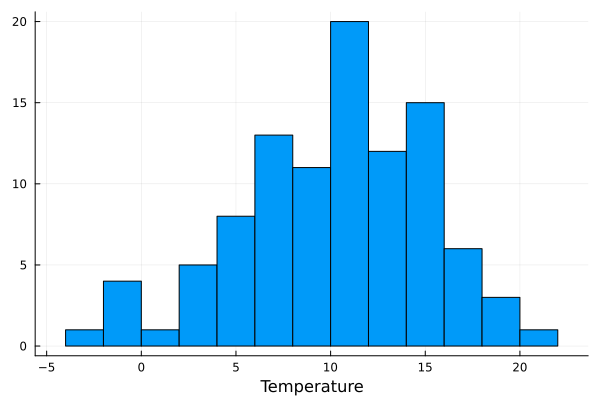

In [5]:
histogram(dataset.temperature,
          xlab = "Temperature",
          bins = 15,
          legend = false)


Scatterplot of temperature (x) impacting rainfall and price (y's):

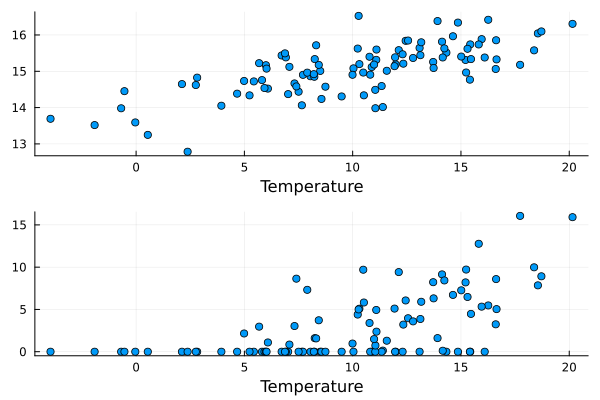

In [6]:
scatter(dataset.temperature,
        Matrix(dataset[!, 2:3]),
        layout = (2, 1),
        xlabel = "Temperature",
        legend = false)

Pearson correlations between temperature and [rainfall, price]:


In [7]:
cor(dataset.temperature,
    Matrix(dataset[!, 2:3]))

1×2 transpose(::Vector{Float64}) with eltype Float64:
 0.723708  0.597355

Scatterplot of demand vs temperature, rainfall and price:

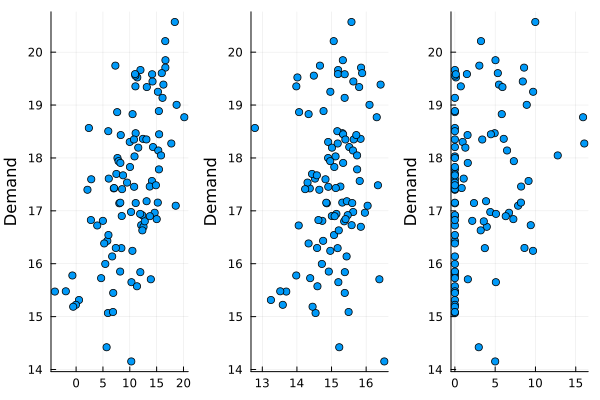

In [8]:
scatter(Matrix(dataset[!, 1:3]),
        dataset.demand,
        layout = (1, 3),
        ylabel = "Demand",
        legend = false)

Pearson correlations between demand and [temperature, rainfall, price]

In [9]:
cor(Matrix(dataset[!, 1:3]),
     dataset.demand)

3×1 Matrix{Float64}:
 0.5536175312242122
 0.17686650182210534
 0.24231978791378633

Questions:
- what's the interpretation of these correlations?
- are correlations consistent with our signs of coefficients? 

### c. Linear Regression estimation using Ordinary Least Squares (OLS)

#### Our own algebraic matrix implementation

Defining an estimating function:


In [10]:
function least_squares(x, y)
    return hcat(ones(size(x)[1]), x) \ y
end

least_squares (generic function with 1 method)

Using this function to estimate our linear regression:

In [11]:
βs = least_squares(Matrix(dataset[!, 1:3]), dataset.demand)


4-element Vector{Float64}:
 29.013747127739393
  0.27394948446808287
 -0.9407633040434895
 -0.04102771224854498

Questions:
1. What's the interpretation of β₁
2. What's the interpretation of β₂
3. What's the interpretation of β₀


#### GLM package implementation

Defining model specification


In [12]:
specification = @formula(demand ~ temperature + price + rainfall)

FormulaTerm
Response:
  demand(unknown)
Predictors:
  temperature(unknown)
  price(unknown)
  rainfall(unknown)

Estimating a specified model on a given dataset:

In [13]:
fitted_OLS = lm(specification, dataset)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + temperature + price + rainfall

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  29.0137      3.2475      8.93    <1e-13  22.5675    35.46
temperature   0.273949    0.0357202   7.67    <1e-10   0.203045   0.344854
price        -0.940763    0.230358   -4.08    <1e-04  -1.39802   -0.483507
rainfall     -0.0410277   0.0360337  -1.14    0.2577  -0.112554   0.0304987
───────────────────────────────────────────────────────────────────────────

Questions:
1. What's the interpretation of Standard Error?
2. What's the interpretation of 95%-Lower and Upper Bounds of Confidence Interval? 
3. How to use p-value Pr(>|t|)?


R² calculation:


In [14]:
R² = r2(fitted_OLS)


0.41949242520701646

Questions:
- What's the interpretation of R-squared?


### e. Demonstration of unbiasedness OLS property using Monte Carlo (MC) simulations


Initializing empty arrays to be populated by MC simulations' results 

In [15]:
estimated_β₀ = Float64[]
estimated_β₁ = Float64[]
estimated_β₂ = Float64[]
estimated_β₃ = Float64[]
p_value_β₃ = Float64[]
estimated_R² = Float64[]


Float64[]

Setting up a number of Monte Carlo simulations:

In [16]:
simulation_number = 10 ^ 5

100000

Running Monte Carlo Simulations:


In [17]:
for i in 1:simulation_number
    dataset = dgp() # Data generation 
    fitted_OLS = lm(specification, dataset) # OLS fitting
    push!(estimated_β₀, coef(fitted_OLS)[1]) # intercept saving
    push!(estimated_β₁, coef(fitted_OLS)[2]) # temperature coefficient saving
    push!(estimated_β₂, coef(fitted_OLS)[3]) # price coefficient saving
    push!(estimated_β₃, coef(fitted_OLS)[4]) # rainfall coefficient saving
    push!(p_value_β₃,
            DataFrame(coeftable(fitted_OLS))[4, 5]) # p-values of rainfall significance test saving
    push!(estimated_R², r2(fitted_OLS)) # coefficient of determination saving
end

Sampling distribution of intercept OLS estimates

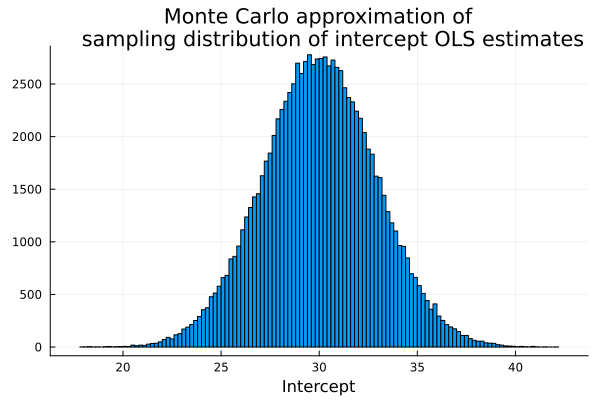

In [18]:
histogram(estimated_β₀,
    title = "Monte Carlo approximation of
    sampling distribution of intercept OLS estimates",
    xlabel = "Intercept",
    legend = false)

Key takeaways from sampling distribution of OLS intercept (β₀) estimates:

In [19]:
println("The intercept (β₀) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[1, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimated_β₀), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimated_β₀), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[1, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimated_β₀, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[1, 6:7]),
        sigdigits = 3),
    ".")


The intercept (β₀) estimated by Ordianary Least Squares (OLS) at the value of ≈28.5 can be considered as a random variable derived from so called sampling distribution that we approximated (see histogram) through Monte Carlo simulations with:
(1) a mean of ≈30.0 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈2.89 being estimated by OLS to be 2.83 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[24.4, 35.7] being estimated by OLS to be [22.8, 34.1].


Sampling distribution of temperature, price and rainfall OLS estimates:

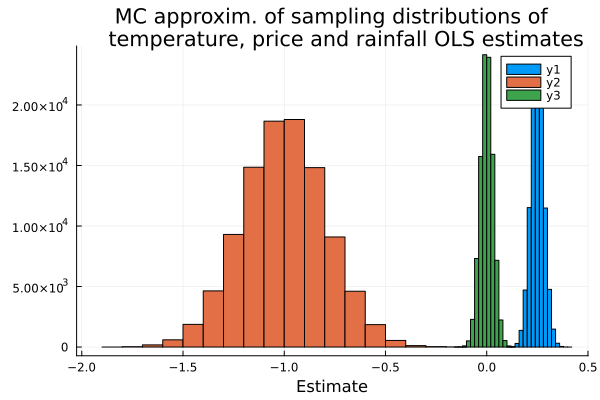

In [20]:
histogram([estimated_β₁, estimated_β₂, estimated_β₃],
    bins = 25, xlabel = "Estimate",
    title = "MC approxim. of sampling distributions of
    temperature, price and rainfall OLS estimates")

Key takeaways from sampling distribution of OLS temperature estimates

In [21]:
println("The temperature impact coefficient (β₁) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[2, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see a blue histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimated_β₁), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimated_β₁), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[2, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimated_β₁, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[2, 6:7]),
        sigdigits = 3),
    ".")

The temperature impact coefficient (β₁) estimated by Ordianary Least Squares (OLS) at the value of ≈0.223 can be considered as a random variable derived from so called sampling distribution that we approximated (see a blue histogram) through Monte Carlo simulations with:
(1) a mean of ≈0.25 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈0.0331 being estimated by OLS to be 0.0353 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[0.185, 0.316] being estimated by OLS to be [0.153, 0.293].


Key takeaways from sampling distribution of price OLS estimates

In [22]:
println("The price impact coefficient (β₂) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[3, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see an orange histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimated_β₂), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimated_β₂), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[3, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimated_β₂, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[3, 6:7]),
        sigdigits = 3),
    ".")

The price impact coefficient (β₂) estimated by Ordianary Least Squares (OLS) at the value of ≈-0.881 can be considered as a random variable derived from so called sampling distribution that we approximated (see an orange histogram) through Monte Carlo simulations with:
(1) a mean of ≈-1.0 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈0.206 being estimated by OLS to be 0.203 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[-1.41, -0.599] being estimated by OLS to be [-1.29, -0.478].


Key takeaways from sampling distribution of rainfall OLS estimates:

In [23]:
println("The rainfall impact coefficient (β₃) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(DataFrame(coeftable(fitted_OLS))[4, 2],
        sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see a green histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimated_β₃), sigdigits = 3),
    " equal to the true value of this parameter (unbiasedness property of an estimator),\n",
    "(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimated_β₃), sigdigits = 3),
    " being estimated by OLS to be ",
    round(DataFrame(coeftable(fitted_OLS))[4, 3],
        sigdigits = 3),
    " - the minimal possible standard error (efficiency property of an estimator),\n",
    "(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimated_β₃, [0.025, 0.975]),
        sigdigits = 3),
    " being estimated by OLS to be ",
    round.(Array(DataFrame(coeftable(fitted_OLS))[4, 6:7]),
        sigdigits = 3),
    ".")

The rainfall impact coefficient (β₃) estimated by Ordianary Least Squares (OLS) at the value of ≈0.0399 can be considered as a random variable derived from so called sampling distribution that we approximated (see a green histogram) through Monte Carlo simulations with:
(1) a mean of ≈-5.3e-5 equal to the true value of this parameter (unbiasedness property of an estimator),
(2) a standard deviation (called standard error of this estimate) of ≈0.0315 being estimated by OLS to be 0.0308 - the minimal possible standard error (efficiency property of an estimator),
(3) 95%-Confidence Interval of ≈[-0.062, 0.062] being estimated by OLS to be [-0.0212, 0.101].


Sampling distribution of rainfall significance test p-values:

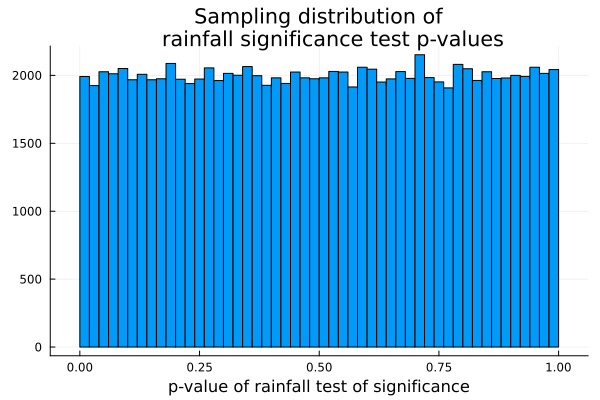

In [24]:
histogram(p_value_β₃,
    xlabel = "p-value of rainfall test of significance",
    title = "Sampling distribution of
    rainfall significance test p-values",
    legend = false)


Key takeaways from Sampling distribution of rainfall significance test p-values:

In [25]:
print("Given the null hypothesis of no impact of rainfall being true the sampling distribution p-value will be uniform on [0, 1] - see a histogram.")
println("As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as α ≈ ",
    round(mean(p_value_β₃ .< 0.05), sigdigits = 3) * 100,
    "% of times."
)
println("Key takeaways:\n",
    "(1) It's unavoidable to make a type I error (false positive), so be aware of it, whenever you claim the impact of X on Y,\n",
    "(2) You're controlling the probability of type I error (false positive) by setting up the significance level α ∈ [0.1%, 1%, 2%, 5%, 10%],\n",
    "(3) However, there's no free lunch, but a trade-off, since the lower the probability of false positive ∈ [0.1%, 1%, 2%, 5%, 10%], the higher the probability of so called type II error (false negative), which is failing to reject a false null hypothesis.")

Given the null hypothesis of no impact of rainfall being true the sampling distribution p-value will be uniform on [0, 1] - see a histogram.As a result, using the significance level of α = 5% will result in rejecting the true null hypothesis (so called type I error or false positive) of no rainflall impact on demand as often as α ≈ 4.95% of times.
Key takeaways:
(1) It's unavoidable to make a type I error (false positive), so be aware of it, whenever you claim the impact of X on Y,
(2) You're controlling the probability of type I error (false positive) by setting up the significance level α ∈ [0.1%, 1%, 2%, 5%, 10%],
(3) However, there's no free lunch, but a trade-off, since the lower the probability of false positive ∈ [0.1%, 1%, 2%, 5%, 10%], the higher the probability of so called type II error (false negative), which is failing to reject a false null hypothesis.


Key takeaways from Sampling distribution of R²

In [26]:
println("The coefficient of determination (R²) estimated by Ordianary Least Squares (OLS) at the value of ≈",
    round(r2(fitted_OLS), sigdigits = 3),
    " can be considered as a random variable derived from so called sampling distribution that we approximated (see a histogram) through Monte Carlo simulations with:\n",
    "(1) a mean of ≈",
    round(mean(estimated_R²), sigdigits = 3),
    "\n(2) a standard deviation (called standard error of this estimate) of ≈",
    round(std(estimated_R²), sigdigits = 3),
    "\n(3) 95%-Confidence Interval of ≈",
    round.(quantile(estimated_R², [0.025, 0.975]),
        sigdigits = 3),
    ".")

The coefficient of determination (R²) estimated by Ordianary Least Squares (OLS) at the value of ≈0.432 can be considered as a random variable derived from so called sampling distribution that we approximated (see a histogram) through Monte Carlo simulations with:
(1) a mean of ≈0.46
(2) a standard deviation (called standard error of this estimate) of ≈0.0732
(3) 95%-Confidence Interval of ≈[0.312, 0.598].


### g. Coefficient biasedness due to correlated omitted variable


Defining a simple but wrong specification omitting both temperature and rainfall:


In [27]:
wrong_specification = @formula(demand ~ price)

FormulaTerm
Response:
  demand(unknown)
Predictors:
  price(unknown)

Estimating a wrongly specified model:

In [28]:
wrong_spec_model = lm(wrong_specification, dataset)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

demand ~ 1 + price

Coefficients:
────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  12.4928      2.63987   4.73    <1e-05   7.25409   17.7316
price         0.336936    0.176818  1.91    0.0596  -0.013953   0.687825
────────────────────────────────────────────────────────────────────────

Initializing an empty array to be popoulated by price coefficients:

In [29]:
price_coefficient = Float64[]

Float64[]

Running Monte Carlo Simulations:

In [30]:
for i in 1:simulation_number
    dataset = dgp() # data generation
    wrong_spec_model = lm(wrong_specification, dataset) # wrong model fitting
    push!(price_coefficient, coef(wrong_spec_model)[2])
 end

Sampling distribution of price coefficient in a wrongly specified model:

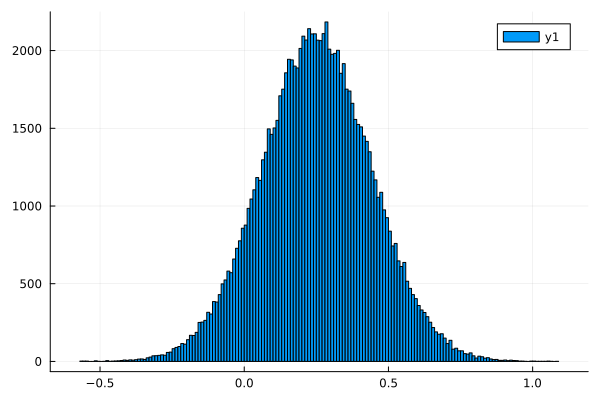

In [31]:
histogram(price_coefficient)

Calculating a bias being a difference between the expected value of an estimate and a true value:

In [32]:
bias =  mean(price_coefficient) - (-1)

1.2504756306309213

Main takeaways from omitted variable problem:


In [33]:
println("OLS estimate of price coefficient is biased, i.e. systematically being wrong with an expected value of ≈",
    round(mean(price_coefficient), sigdigits = 3),
    ".\nGiven a true price coefficient value of -1, the total bias is equal to (",
    round(mean(price_coefficient), sigdigits = 3),
    " - (-1)) = ", round(bias, sigdigits = 3))
println("This bias is due to the omitted variable, i.e. temperature, being correlated with both price and demand, e.g. ommiting a rainfall doesn't result in bias even though rainfall is correlated with price but not with a demand.")
println("Since the temprerature is positivaly correlated with both demand and price, when ommited its postive impact on demand is overtaken by the price.") 


OLS estimate of price coefficient is biased, i.e. systematically being wrong with an expected value of ≈0.25.
Given a true price coefficient value of -1, the total bias is equal to (0.25 - (-1)) = 1.25
This bias is due to the omitted variable, i.e. temperature, being correlated with both price and demand, e.g. ommiting a rainfall doesn't result in bias even though rainfall is correlated with price but not with a demand.
Since the temprerature is positivaly correlated with both demand and price, when ommited its postive impact on demand is overtaken by the price.


Questions:
- Is it really a problem? Short answer: not, if it's predictive task
- When it's a problem? Short answer: when optimal price will be determined by a model  
- If it's a problem, how to fix it?
    - having a lot of controlling variables, i.e. in practice you never know what impacts what 
    - econometric toolkit (this is where econometrics distinguish from statistics and machine learning):
        - Instrumental Variables estimation
        - Simultenous Equations